In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect


In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
# view_mtest = session.query(Measurement)
# view_mtest.__dict__
print("Measurement columns include")
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])
    
print("------------")

print("Station columns include")
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

Measurement columns include
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
------------
Station columns include
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Calculate the date 1 year ago from the last data point in the database
date_max=session.query(func.max(Measurement.date))
for item in date_max:
    print(item)

query_date = dt.date(2017,8,23) - dt.timedelta(days=365)



('2017-08-23',)


# Exploratory Climate Analysis

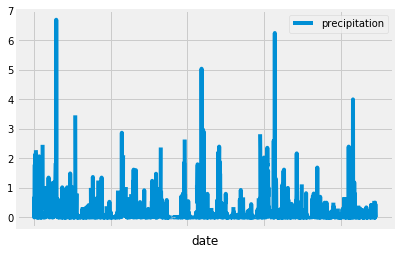

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Perform a query to retrieve the data and precipitation scores

year_of_query=session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).\
    order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

df=pd.DataFrame(columns=['date', 'precipitation'])
for item in year_of_query:
    df = df.append({'date': item.date,'precipitation':item.prcp}, ignore_index=True)
df=df.set_index('date').sort_values('date', ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()



In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
station_count=session.query(Station).count()
station_count
#stations=session.query(Station)
# for item in stations:
#     print(item.station)

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_id_count=session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    all()

station_id_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

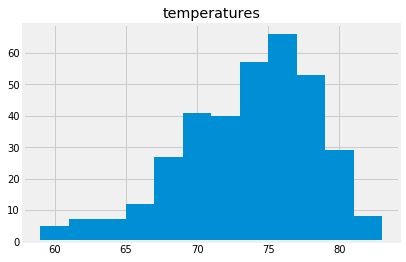

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_id=station_id_count[0][0]

most_active_query=session.query(Measurement.date,Measurement.tobs).\
    filter(Measurement.station == most_active_id).\
    filter(Measurement.date >= query_date).\
    order_by(Measurement.date.desc()).all()

most_active_df=pd.DataFrame(columns=['date','temperatures'])

for item in most_active_query:
    most_active_df = most_active_df.append({'date': item.date,'temperatures':item.tobs}, ignore_index=True)

hist = most_active_df.hist(bins=12)



In [17]:
# Using the station id from the previous query, calculate the lowest temperature
# recorded, highest temperature recorded, and average temperature most active station?


min_temp=session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == most_active_id)[0]
for item in min_temp:
    print(item)
max_temp=session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == most_active_id)[0]
for item in max_temp:
    print(item)
avg_temp=session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_id)[0]
for item in avg_temp:
    print(item)

54.0
85.0
71.66378066378067


![precipitation](Images/station-histogram.png)

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_start_rep = dt.date(2018,6,1) - dt.timedelta(days=365)
trip_end_rep = dt.date(2018,6,13) - dt.timedelta(days=365)

calc_temps_results=calc_temps(trip_start_rep, trip_end_rep)
tmin=calc_temps_results[0][0]
tavg=calc_temps_results[0][1]
tmax=calc_temps_results[0][2]
calc_temps_results

[(72.0, 77.4578313253012, 83.0)]

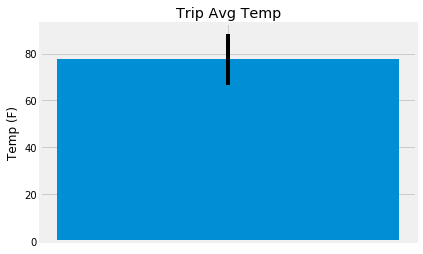

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar('',tavg,yerr=(tmax-tmin))
plt.title('Trip Avg Temp')
plt.ylabel("Temp (F)")
plt.show()

In [21]:
#Calculate the total amount of rainfall per weather station 
# for your trip dates using the previous year's matching dates.
#Sort this in descending order by precipitation amount and list the 
# station, name, latitude, longitude, and elevation

station_rainfall_total=session.query(Measurement.station, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= trip_start_rep).\
    filter(Measurement.date <= trip_end_rep).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).\
    all()
station_rainfall_total

[('USC00516128', 21.3331, -157.8025, 152.4, 3.01),
 ('USC00519281', 21.45167, -157.84888999999998, 32.9, 2.21),
 ('USC00513117', 21.4234, -157.8015, 14.6, 1.52),
 ('USC00514830', 21.5213, -157.8374, 7.0, 1.5100000000000002),
 ('USC00519523', 21.33556, -157.71139, 19.5, 0.7000000000000001),
 ('USC00519397', 21.2716, -157.8168, 3.0, 0.16),
 ('USC00517948', 21.3934, -157.9751, 11.9, None)]

## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
# daily_normals("01-01")
# [(62.0, 69.15384615384616, 77.0)]

In [132]:
trip_start="2018-06-01"
trip_end="2018-06-13"

trip_start = dt.datetime.strftime(dt.datetime.strptime(trip_start, '%Y-%m-%d'), "%m-%d-%Y")
trip_end = dt.datetime.strftime(dt.datetime.strptime(trip_end, '%Y-%m-%d'), "%m-%d-%Y")


print(daily_normals(trip_start[0:5]))
print(daily_normals(trip_end[0:5]))
print(trip_start)


[(64.0, 74.6140350877193, 81.0)]
[(68.0, 75.66666666666667, 81.0)]
06-01-2018


In [171]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

start = dt.datetime.strptime(trip_start, '%m-%d-%Y')
end = dt.datetime.strptime(trip_end, '%m-%d-%Y')
step = dt.timedelta(days=1)
trip_range=[start]
while start < end:
    start += step
    trip_range.append(start.date())

trip_range_new=[]
for item in trip_range:
    trip_range_new.append(str(item)[5:10])

for item in trip_range_new:
    print(f"The daily normals for {item} are:\
    minimum {daily_normals(item)[0][0]}\
    average {daily_normals(item)[0][1]}\
    maximum {daily_normals(item)[0][2]}")



The daily normals for 06-01 are:    minimum 64.0    average 74.6140350877193    maximum 81.0
The daily normals for 06-02 are:    minimum 65.0    average 74.4    maximum 81.0
The daily normals for 06-03 are:    minimum 65.0    average 74.03448275862068    maximum 80.0
The daily normals for 06-04 are:    minimum 65.0    average 73.81818181818181    maximum 81.0
The daily normals for 06-05 are:    minimum 68.0    average 74.85454545454546    maximum 81.0
The daily normals for 06-06 are:    minimum 70.0    average 75.17543859649123    maximum 80.0
The daily normals for 06-07 are:    minimum 68.0    average 75.07142857142857    maximum 81.0
The daily normals for 06-08 are:    minimum 70.0    average 75.58620689655173    maximum 81.0
The daily normals for 06-09 are:    minimum 69.0    average 75.15254237288136    maximum 81.0
The daily normals for 06-10 are:    minimum 68.0    average 75.14285714285714    maximum 81.0
The daily normals for 06-11 are:    minimum 69.0    average 76.01960784313

In [196]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
mins=[]
avgs=[]
maxs=[]


for item in trip_range_new:
    mins.append(daily_normals(item)[0][0])
    avgs.append(daily_normals(item)[0][1])
    maxs.append(daily_normals(item)[0][2])

    
d = {'dates': trip_range_new, 'mins': mins, 'avgs': avgs, 'maxs':maxs}
df = pd.DataFrame(data=d).set_index('dates')
df
    
    

,mins,avgs,maxs
dates,,,
06-01,64.0,74.614035,81.0
06-02,65.0,74.400000,81.0
06-03,65.0,74.034483,80.0
06-04,65.0,73.818182,81.0
06-05,68.0,74.854545,81.0
06-06,70.0,75.175439,80.0
06-07,68.0,75.071429,81.0
06-08,70.0,75.586207,81.0
06-09,69.0,75.152542,81.0


Text(0, 0.5, 'Temperature (F)')

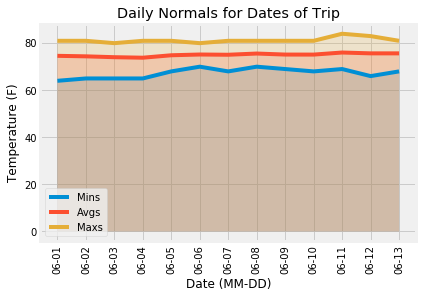

In [226]:
# Plot the daily normals as an area plot with `stacked=False`



plt.fill_between(df.index, df['mins'], alpha=0.2)
plt.fill_between(df.index, df['avgs'], alpha=0.2)
plt.fill_between(df.index, df['maxs'], alpha=0.2)

plt.plot(df.index, df[['mins','avgs','maxs']])
 
# Add titles
plt.title("Daily Normals for Dates of Trip", loc="center")
plt.xticks(rotation=90)
plt.xlabel("Date (MM-DD)")
plt.legend(["Mins", "Avgs", "Maxs"])
plt.ylabel("Temperature (F)")

